In [180]:
import numpy as np
import pandas as pd
import os
import torch
import torchvision
import cv2
import pandas
import random
import faiss
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
from mpl_toolkits.mplot3d import axes3d
from  PIL import Image
from time import time
from torch import nn
from torchvision import models
from torchvision import transforms
from torchvision import datasets
from torch.utils.data.dataset import Dataset
from torchsummary import summary

from sklearn.decomposition import PCA
from sklearn import preprocessing

torch.cuda.is_available()

True

In [181]:
resnet= models.resnet152(pretrained=True)
# resnet = models.resnet152(pretrained=True)
# freeze all base layers; Parameters of newly constructed modules have requires_grad=True by default
for param in resnet.parameters():
    param.requires_grad = False
num_ftrs = resnet.fc.in_features



print(num_ftrs)
# resnet = torch.nn.Sequential(*(list(resnet.children())[:-1]))




2048


In [210]:
class Identity(torch.nn.Module):
    def init(self):
        super(Identity, self).init()

    def forward(self, x):
        return x

resnet.fc = Identity() # Remove the prediction head

In [211]:
def load_images_from_folder(folder, end, as_tensor = False):
        
    images = []
    num_img = []
    file_count= 0
    dirnames = [] 


    for _, dirnames, filenames in os.walk(folder):

        if dirnames != []:
            subfolders = dirnames
        current_path = os.path.join(folder, subfolders[file_count])
        num_img.append(len(os.listdir(current_path)))
        for filename in os.listdir(current_path):
                if as_tensor:
                    img = cv2.imread(os.path.join(current_path, filename))
                    if img is not None:    
                        img = torch.from_numpy(img).type(torch.uint8)               
                        images.append(img)
                        
                else:
                    img = Image.open(os.path.join(current_path, filename))
                    if img is not None:    
                        images.append(img)

 

        file_count += 1
        
        if file_count % 10 == 0:
            print('number of folder done =', file_count, 'total number of images so far =', len(images))
            
        if file_count  == end:
            return images, num_img

    return images, num_img


def show_image(PIL_img):
    plt.figure()
    plt.imshow(PIL_img)
#     PIL_img.show()


In [212]:

def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy()
    inp.transpose((0, 2, 1))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)

    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

def show_tensor_image(image_tensor, preprocess = False):
    # use this code when showing the images
    inp = image_tensor.numpy()
    if preprocess:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        inp = std * inp + mean
        inp = np.clip(inp, 0, 1)

    im2 = inp.copy()
    im2[:, :, 0] = image_tensor[:, :, 2]
    im2[:, :, 2] = image_tensor[:, :, 0]
    plt.imshow(im2)


In [213]:
# the path where the folder is
path = r'C:\Users\richa\Desktop\projects\Bristol uni porjects\Univecity projects\Applied Data Science\uob_image_set'

N_CHANNELS = 3

images, num_images = load_images_from_folder(path, 100, as_tensor= False)



number of folder done = 10 total number of images so far = 42
number of folder done = 20 total number of images so far = 87
number of folder done = 30 total number of images so far = 128
number of folder done = 40 total number of images so far = 175
number of folder done = 50 total number of images so far = 219
number of folder done = 60 total number of images so far = 265
number of folder done = 70 total number of images so far = 307
number of folder done = 80 total number of images so far = 349
number of folder done = 90 total number of images so far = 390
number of folder done = 100 total number of images so far = 436


In [214]:
# using the mean and std values form the ImageNet data for which it was pretrained
preprocess = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406], 
            std=[0.229, 0.224, 0.225]
        )])


In [215]:
def preprocess_and_batch(image_list):
    list_input_tensor = []
    list_input_batch = []
    
    for item in range(len(image_list)):
        input_tensor = preprocess(image_list[item])
        input_batch = input_tensor.unsqueeze(0)
        list_input_tensor.append(input_tensor)
        list_input_batch.append(input_batch)
    return list_input_batch, list_input_tensor

list_input_batch, list_input_tensor= preprocess_and_batch(images)
print(list_input_batch)


[tensor([[[[2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          ...,
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489],
          [2.2489, 2.2489, 2.2489,  ..., 2.2489, 2.2489, 2.2489]],

         [[2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          ...,
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286],
          [2.4286, 2.4286, 2.4286,  ..., 2.4286, 2.4286, 2.4286]],

         [[2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 2.6400, 2.6400, 2.6400],
          [2.6400, 2.6400, 2.6400,  ..., 

In [216]:
def feed_batch_to_network(list_input_batch, network):
    output_array = []
    for i in range(len(list_input_batch)):
        if torch.cuda.is_available():
            input_batch = list_input_batch[i].to('cuda')
            resnet.to('cuda')
        else:
            input_batch = list_input_batch[i].to('cpu')
            resnet.to('cpu')
            
        with torch.no_grad():
            output = network(input_batch)
            cpu_tensor = output.cpu()
            pos = cpu_tensor[0].tolist()       
            output_array.append(pos)
    output_array = np.asarray(output_array)
    return output_array

network_output = feed_batch_to_network(list_input_batch, resnet)
print(network_output)


[[[[0.8092553 ]]

  [[0.49364033]]

  [[0.89196754]]

  ...

  [[0.41578254]]

  [[0.43366763]]

  [[0.41890946]]]


 [[[0.80897552]]

  [[0.41189054]]

  [[0.85137326]]

  ...

  [[0.43676457]]

  [[0.40877602]]

  [[0.41408405]]]


 [[[0.8791945 ]]

  [[0.43206921]]

  [[0.89675301]]

  ...

  [[0.39340732]]

  [[0.4039889 ]]

  [[0.48032853]]]


 ...


 [[[0.82587874]]

  [[0.52310741]]

  [[0.82823443]]

  ...

  [[0.47262445]]

  [[0.31364149]]

  [[0.44863299]]]


 [[[0.7834031 ]]

  [[0.53698283]]

  [[0.77604026]]

  ...

  [[0.39655054]]

  [[0.32365799]]

  [[0.46439847]]]


 [[[0.75529277]]

  [[0.50069171]]

  [[0.8029682 ]]

  ...

  [[0.36433581]]

  [[0.40610301]]

  [[0.41954798]]]]


In [217]:

# def output_3d_plot(num_images):

#     fig = plt.figure()
#     ax = plt.axes(projection="3d")

#     img_counter = 0
#     for n in num_images:
#         r = lambda: random.randint(0,255)
#         random_color = '#%02X%02X%02X' % (r(),r(),r())
#         ax.scatter(network_output[img_counter:img_counter + n,0], network_output[img_counter:img_counter + n,1], network_output[img_counter:img_counter + n,2],color=random_color,s=20)
#         img_counter += n


#     ax.set_xlabel('X Axes')
#     ax.set_ylabel('Y Axes')
#     ax.set_zlabel('Frame Axes')

#     plt.show()


In [218]:
# def output_2d_plot(network_output,num_images, dimension_1, dimension_2):
#     # dimension numbers = 0, 1, 2
#     fig = plt.figure()
#     img_counter = 0
#     for n in num_images:
#         r = lambda: random.randint(0,255)
#         random_color = '#%02X%02X%02X' % (r(),r(),r())
#         plt.plot(network_output[img_counter:img_counter + n,dimension_1],network_output[img_counter:img_counter + n,dimension_2], 'o',color=random_color)
#         img_counter += n
#     plt.xlabel("dimension1")
#     plt.ylabel("dimension2")
#     plt.show()            
# # output_2d_plot(network_output,num_images, 0, 1)

In [219]:
# scaled_data = preprocessing.scale(network_output)
# pca = PCA()
# pca.fit(scaled_data)
# pca_data = pca.transform(scaled_data)
# per_var = np.round(pca.explained_variance_ratio_*100, decimals = 1)
# per_var

# labels = ['PC' +  str(x) for x in range(1,len(per_var)+1)]
# plt.bar(x=range(1,len(per_var)+1), height=per_var)
# plt.xlabel("principal components")
# plt.ylabel("explained variannce")
# plt.show()

In [220]:

# pca_df = pd.DataFrame(pca_data, columns=labels)

# def pca_2d_plot(pca_df, num_images, dimension_1, dimension_2):
#     fig = plt.figure()
#     img_counter = 0
#     for n in num_images:
#         r = lambda: random.randint(0,255)
#         random_color = '#%02X%02X%02X' % (r(),r(),r())
#         plt.plot(dimension_1[img_counter:img_counter + n], dimension_2[img_counter:img_counter + n], 'o',color=random_color)
#         img_counter += n
#     plt.xlabel("dimension1")
#     plt.ylabel("dimension2")
#     plt.show()
# pca_2d_plot(pca_df, num_images, pca_df.PC1,  pca_df.PC2)

In [221]:
len(network_output[0])

2048

In [222]:
def display_simllar_images(img_target, network_output, show_img = False):
    equidian_difference_list = []
    for images in network_output:
        equidian_difference = np.linalg.norm(img_target - images)
        equidian_difference_list.append(equidian_difference)
    equidian_difference_array = np.array(equidian_difference_list)
    sort_index = np.argsort(equidian_difference_array)
    
    return sort_index

In [223]:
 def show_similar_img(images_order, number_similar_img):
    fig = plt.figure()
    for i in range(0,number_similar_img):
        plt.subplot(2, 5, i+1)
        plt.imshow(images[images_order[i]])
        plt.axis('off')

    plt.show()

In [230]:
images_order = display_simllar_images(network_output[0], network_output, show_img=True)
images_order

array([  0,   3,   2,  56, 388, 211, 155,  41, 364,  54, 346, 133, 161,
       418, 305, 236, 234, 357, 153, 196, 340, 169, 106, 226, 398, 102,
       416, 243, 376, 163, 280, 323, 242, 302, 241, 392, 409, 193, 301,
       271, 170, 361, 245, 132, 104,  53, 268, 237, 247, 381, 281,  92,
       377, 213, 205, 404, 185, 375, 156, 103, 151,  57, 164, 162, 227,
       278, 194, 339,  13, 121, 348,  30, 288,  61, 138,  73, 101, 168,
       360, 240, 327, 352,  89,  32,  82, 382, 275, 393,  88, 123, 283,
       282, 119, 118, 252,  86, 239,  93, 220, 122, 224, 397, 389, 334,
       347, 372,  87, 166, 238, 412, 292, 390, 109, 105,  74,  95, 231,
       135, 338,  66, 267, 314, 326, 225, 223, 306, 110, 265, 313, 222,
       356,  14, 140, 351, 150, 249,  19, 304,  85, 251, 128,  83, 329,
       219, 333, 374, 399,  52, 359, 250, 260, 336, 331, 100,  67, 414,
       145, 120, 273,   4, 312,   1, 214, 330, 142, 317, 218, 405, 184,
       158,  39, 274, 144,  15, 385, 269,  58, 154, 384, 111, 12

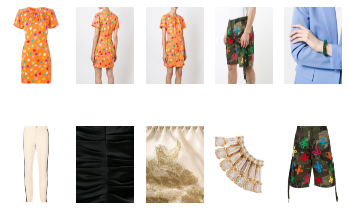

In [231]:
show_similar_img(images_order, number_similar_img=10)

In [199]:
# dimensions =3
# n = sum(num_images)    # number of vectors                   

# def shuffle_vectors(num_vectors, vector_dimension):
#     np.random.seed(1)  
#     # random shuffle of vectors          
#     db_vectors = np.random.random((num_vectors, vector_dimension)).astype('float32')
#     return db_vectors
# db_vectors = shuffle_vectors(n,dimensions)

# def index_vector_space(num_clusters, vector_dimension):
#     # to assign the vectors to a particular cluster. This is usually another index that uses the L2 distance metric (we use the FlatL2 index)
#     quantiser = faiss.IndexFlatL2(vector_dimension)  
#     index = faiss.IndexIVFFlat(quantiser, vector_dimension, num_clusters,   faiss.METRIC_L2)

#     return quantiser, index

# quantiser, index = index_vector_space(8, dimensions)



In [200]:
# def train_index(index, expected_num_images = None):
#     # TODO make sure index is not already trained
#     if index.is_trained:
#         return print("index has been trained")
#     index.train(db_vectors)  # train on the database vectors
#     print(index.ntotal)   # 0
#     index.add(db_vectors)   # add the vectors and update the index
#     print(index.is_trained)  # True
#     print(index.ntotal)   # number of images
#     print("equal", len(images) == index.ntotal)
#     if expected_num_images is not None:
#         assert index.ntotal == expected_num_images, "index total does not match expected number of images"

# train_index(index, 42)

In [201]:

# def search_n_clusters(index, num_clusters, num_search_results, vector_dimension, num_query_vec = 1,):
#     nprobe = num_clusters  # nprobe parameter specifies the number of clusters to visit during the search operation (nprobe<nlist). hyper-parameter which can be tuned         for different results
#     n_query = num_query_vec
#     # ‘k’ specifies the number of similar vectors to be returned from the visited clusters.
#     k = num_search_results  # return 3 nearest neighbours

#     np.random.seed(0)   
#     query_vectors = np.random.random((n_query, vector_dimension)).astype('float32')
#     print(query_vectors)
#     #  search operation will return the ids (row numbers or index in the vector store) of the k most similar vectors for each query vector along with their respective          distances
#     distances, indices = index.search(query_vectors, k)

#     return distances, indices


# distances, indices = search_n_clusters(index, 8,15,
# dimensions,num_query_vec = 42)
